In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import torchvision.transforms as _T
from torch.utils.data import DataLoader
import librosa
import sys
sys.path.append("../")
from dataloaders.rawaudiodataset import RawAudioDataset
from dataloaders.audiodataset  import AudioDataset

In [2]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  im = axs.imshow(spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def get_spectrogram(waveform,
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

In [3]:
def _custom_collate(batch_):
    def contains_none(b):
        for elem in b:
            if elem is None:
                return False
        return True
    batch = list(filter(lambda x: contains_none(x), batch_))
    input = torch.stack([b[0] for b in batch])
    label = torch.stack([b[1] for b in batch])
    if len(batch[0]) == 2:
        return input, label
    filepath = [b[2] for b in batch]
    return input, label, filepath

In [4]:

sample_file = "/Users/test/Documents/Projects/Master/birds-generation/data/cleaned_train/Alaarv_song/nips4b_birds_trainfile604-a691a8.npy"
audio_spec = np.load(sample_file)
audio_spec.shape


(128, 172)

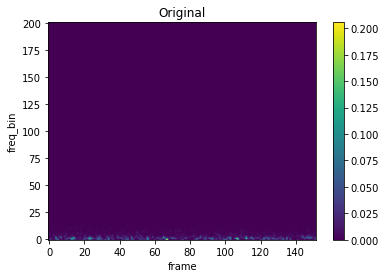

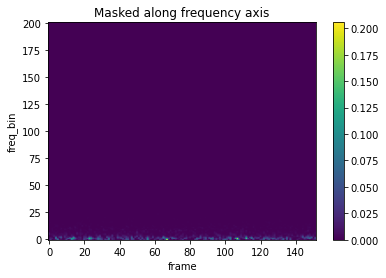

In [5]:
audio_file =  os.path.splitext(sample_file)[0]+".wav"
assert os.path.isfile(audio_file), (audio_file, sample_file)
audio, sr = torchaudio.load(audio_file)
spec = get_spectrogram(audio)
plot_spectrogram(spec[0], title="Original")

# masking = T.FrequencyMasking(freq_mask_param=80)
# spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along frequency axis")

In [6]:
#Instantiate an object of the class rawaudiodataset
classes = os.listdir("../../data/cleaned_train") 
#remove .DS_Store from the list of classes
classes = [x for x in classes if x != ".DS_Store"]
print("Classes in the dataset: ", classes)

# transform = T.FrequencyMasking(freq_mask_param=80)
transform = _T.Compose(
    [
        T.FrequencyMasking(freq_mask_param=10),
        T.TimeMasking(time_mask_param=10),
        _T.Resize(size=(512, 32))
    ]
)

# transform = []
#Create a dataset object
dataset = RawAudioDataset(data_path="../../data/cleaned_train.txt", root_dir="../../data/", classes_name=classes, sr=16000, window_length=16384, use_spectrogram=True, transform=transform)
# dataset = AudioDataset(data_path="../../data/cleaned_train.txt", root_dir="../../data/", classes_name=classes, sr=16000, window_length=16384, use_spectrogram=True, transforms=transform)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=_custom_collate)
for i, sample in enumerate(dataloader):
  print(sample[0].shape, sample[1])
  # plot_spectrogram(sample[0], title="Original")
  # if i > 10:
    # break

Classes in the dataset:  ['Turphi_song', 'Alaarv_song', 'Galcri_call', 'Parate_song', 'Erirub_song', 'Cetcet_song', 'Serser_song', 'Sylcan_song', 'Turmer_call', 'Sylcan_call']
All file paths:  177
Data paths:  177
Transforming audio:  torch.Size([1, 513, 28])
Transformed audio:  torch.Size([1, 512, 32])
Transformed audio final:  torch.Size([3, 512, 32]) tensor(0) tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Transforming audio:  torch.Size([1, 513, 60])
Transformed audio:  torch.Size([1, 512, 32])
Transformed audio final:  torch.Size([3, 512, 32]) tensor(1) tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])
Transforming audio:  torch.Size([1, 513, 71])
Transformed audio:  torch.Size([1, 512, 32])
Transformed audio final:  torch.Size([3, 512, 32]) tensor(9) tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
torch.Size([3, 3, 512, 32]) tensor([0, 1, 9])
Transforming audio:  torch.Size([1, 513, 12])
Transformed audio:  torch.Size([1, 512, 32])
Transformed audio final:  torch.Size([3, 512, 32]) tensor(4) tensor([[